In [1]:
library(tidyverse)

library(ggrepel)
# library(DOSE)
# library(org.Mm.eg.db)
# library(clusterProfiler)
# library(enrichplot)
# library(msigdbr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


In [2]:
setwd('/home/wpy/stereoseq/20240502-SPACseq')
deseq2_out <- read.csv('./bulkdata/Group_CD44PBS_vs_interPBS_DESeq2.txt', sep = '\t')
pbs_results <- deseq2_out

In [3]:
deseq2_out_sorted <- deseq2_out %>%
  filter(!is.na(padj)) %>%
  arrange(padj)

Warning message:
“ggrepel: 675 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


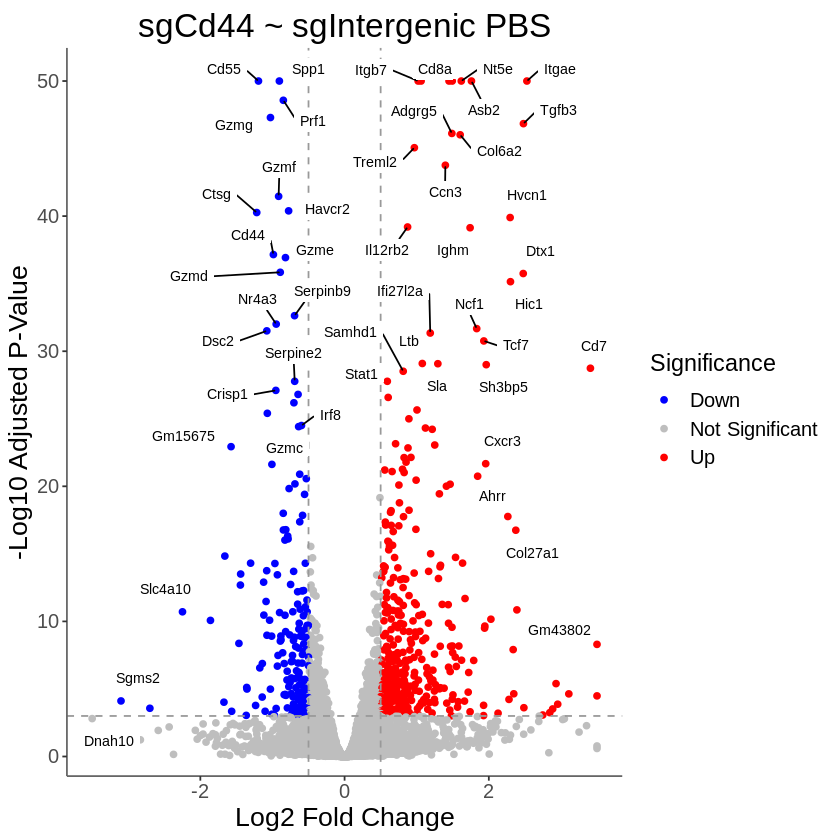

In [4]:
# library(ggplot2)
# library(ggrepel)

tab <- deseq2_out_sorted

tab$padj <- ifelse(tab$padj < 1e-50, 1e-50, tab$padj)
tab$log2FoldChange <- ifelse(tab$log2FoldChange > 3.5, 3.5, tab$log2FoldChange)
tab$log2FoldChange <- ifelse(tab$log2FoldChange < -3.5, -3.5, tab$log2FoldChange)

# Assign colors based on fold change and significance
tab$color <- 'Not Significant'
tab$color[tab$log2FoldChange > 0.5 & tab$padj < 0.001] <- 'Up'
tab$color[tab$log2FoldChange < -0.5 & tab$padj < 0.001] <- 'Down'
tab$color <- factor(tab$color, levels = c('Down', 'Not Significant', 'Up'))

# Create the plot with soft colors and labeled genes
p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = color), size = 1.5) +
  scale_color_manual(values = c("blue", "gray", "red")) +  # 改为红色和蓝色
  theme_classic() +
  labs(
    title = "sgCd44 ~ sgIntergenic PBS",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-3.5, 3.5), ylim = c(1, 50)) +
  geom_hline(yintercept = -log10(0.001), linetype = "dashed", color = "gray60") +
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "gray60") +
  geom_label_repel(
    data = subset(tab, (padj < 0.01) & (abs(log2FoldChange) > 0.5)),
    aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.4,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, vjust = 0.3),  # Title size
    axis.title = element_text(size = 16),  # Axis title size
    axis.text = element_text(size = 12),   # Axis label size
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),  # Legend text size
    axis.line = element_line(size = 0.5, color = "gray40"), # Softer axis lines
    panel.grid.major = element_blank(), panel.grid.minor = element_blank() # Clean gridlines
  )

# Save the plot
# ggsave('./plots/sgIntergenic_vs_sgCd44_PBS.pdf', p, dpi=600)

print(p)

In [6]:
tab %>% write.table('./bulkdata/Group_sgCd44PBS_vs_sgIntergenicPBS_DESeq2_clean.txt', sep='\t', quote=F)

In [55]:
gene_list <- tab %>% filter(padj < 0.05) %>% pull(log2FoldChange)
names(gene_list) <- tab %>% filter(padj < 0.05) %>% pull(Gene_name)
head(gene_list)

Itgae      Cd8a     Cd160      Asb2     Trgc1      Spp1 
 2.527969  1.060841  1.448469  1.758915  1.492523 -0.904273

In [56]:
library(msigdbr)

# Get MSigDB immune-related gene sets for mouse (C7 category)
immune_sets <- msigdbr(species = "Mus musculus", category = "C7") %>%
  dplyr::select(gs_name, gene_symbol)  # Ensure you're using gene symbols

# If your geneList is based on ENSEMBL or other identifiers, convert the immune_sets to match
# For example, if your geneList is in ENSEMBL, you can convert immune_sets as follows:
# immune_sets <- bitr(immune_sets$gene_symbol, fromType = "SYMBOL", toType = "SYMBOL", OrgDb = org.Mm.eg.db)

# Prepare geneList and ensure it is sorted
geneList <- sort(gene_list, decreasing = TRUE)

# Run GSEA
gsea_results <- GSEA(geneList, TERM2GENE = immune_sets, pvalueCutoff = 2, minGSSize = 1, maxGSSize = 1000)

preparing geneSet collections...

GSEA analysis...

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (0.04% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”
Warning message in fgseaMultilevel(pathways = pathways, stats = stats, minSize = minSize, :
“For some pathways, in reality P-values are less than 1e-10. You can set the `eps` argument to zero for better estimation.”
leading edge analysis...

done...



In [54]:
length(geneList)

[1] 116

In [74]:
gsea_results@result[grep('MEM',gsea_results@result$ID),]
# gsea_results@result[grep('Tcf7',gsea_results@result$core_enrichment),]

,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
GSE16522_MEMORY_VS_NAIVE_ANTI_CD3CD28_STIM_CD8_TCELL_DN,GSE16522_MEMORY_VS_NAIVE_ANTI_CD3CD28_STIM_CD8_TCELL_DN,GSE16522_MEMORY_VS_NAIVE_ANTI_CD3CD28_STIM_CD8_TCELL_DN,88,0.6037682,2.464980,1.000000e-10,0.0000005184,4.491579e-07,519,"tags=56%, list=21%, signal=46%",Itgae/Actn2/Hvcn1/Ggt1/Ncf1/Ifit1bl1/Trib2/Slamf1/Abca3/Myl10/Cd160/Gm2a/Ctss/Irf7/Tbkbp1/Ube2l6/Ifi27l2a/Ahr/Tmtc4/Cd8a/Itgb7/H2-Oa/H2-DMa/Treml2/Lag3/Oas1a/Tesc/Limd2/Ctsz/Smpdl3a/Samhd1/Zbp1/Gbp2/Lgals9/Hsd11b1/Map4k1/Idh2/Hsh2d/Psmb10/Cd8b1/Rnf213/Stat1/Irgm2/Isg20/Socs2/Lgals3bp/Irf1/Plcg1/Il18bp
GSE36476_CTRL_VS_TSST_ACT_40H_MEMORY_CD4_TCELL_YOUNG_DN,GSE36476_CTRL_VS_TSST_ACT_40H_MEMORY_CD4_TCELL_YOUNG_DN,GSE36476_CTRL_VS_TSST_ACT_40H_MEMORY_CD4_TCELL_YOUNG_DN,64,0.5737284,2.235841,7.770797e-07,0.0002685587,2.326877e-04,854,"tags=84%, list=34%, signal=57%",Brca2/Cenpm/Kif2c/Il12rb2/Kif20a/Cdkn3/Cdc20/Ska1/Chaf1a/Kif18b/Espl1/Cenps/Kif23/Aurkb/Mcm5/Cdca8/Mcm2/Birc5/Cdca3/Stmn1/Mcm7/Ccnb2/Racgap1/Ccnb1/Mcm10/Ube2c/Mki67/Tpx2/Aspm/Spag5/Hjurp/Fabp5/Tubg1/Tyms/Cdc45/Exosc4/Trip13/Pclaf/Nusap1/Tubb5/Rad54l/Top2a/Hmmr/Fen1/Tuba1b/Kcnk5/Lig1/Kif11/Tk1/Fancg/Rad51/Ncapg/Pola2/Ncaph
GSE12366_NAIVE_VS_MEMORY_BCELL_UP,GSE12366_NAIVE_VS_MEMORY_BCELL_UP,GSE12366_NAIVE_VS_MEMORY_BCELL_UP,38,0.6144378,2.169703,1.151665e-05,0.0018091608,1.567513e-03,553,"tags=53%, list=22%, signal=42%",Cd79b/Dtx1/Lims2/Ighm/Marchf3/Ifi44/S1pr1/Sla/Abcb1a/Zcchc18/Treml2/Cd72/Myadm/Gnb4/Satb1/Tmem71/Ogfrl1/Slc25a53/Ppard/Plekha1
GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_YOUNG_DN,GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_YOUNG_DN,GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_YOUNG_DN,61,0.5457850,2.101346,1.024355e-05,0.0018091608,1.567513e-03,854,"tags=84%, list=34%, signal=57%",Cenpm/Kif2c/Foxm1/Kif20a/Bub1b/Cdkn3/Cdc20/Kifc1/Espl1/Cenps/Mcm5/Cdca8/Oip5/Mcm2/Fbxo5/Birc5/Cdca3/Fanci/Dlgap5/Stmn1/Mcm7/Aurka/Ccnb2/Ccnb1/Mcm10/Polq/Ube2c/Mki67/Neil3/Bdh1/Elovl6/Aspm/Spag5/Fabp5/Tubg1/Tyms/Cdc45/Exosc4/Pclaf/Nusap1/Rad54l/Top2a/Hmmr/Fen1/Tuba1b/Kif11/Tk1/Rad51/Ncapg/Pola2/Ncaph
GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_UP,GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_UP,GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_UP,70,0.5060901,1.996783,4.490651e-05,0.0049530928,4.291514e-03,711,"tags=60%, list=28%, signal=44%",Itgae/Actn2/Ifit1bl1/Rflnb/Rapgef4/Irf7/Ifi27l2a/Ltb/Cd8a/Cd5/Rgs10/H2-Oa/Slc12a7/Tnnt1/Arhgap39/Isg15/Ifit1/Tmem50b/Kif23/Satb1/Snrk/Idh2/Irgm2/Isg20/Lgals3bp/St8sia1/Pdk1/Il6st/Rasgrp2/Ntpcr/Elovl6/Actn1/Mgst2/Tuba1a/Nsmce1/Prkd2/Stk10/Cytip/Tubb5/Top2a/Cyb5a/Noct
GSE16522_MEMORY_VS_NAIVE_CD8_TCELL_DN,GSE16522_MEMORY_VS_NAIVE_CD8_TCELL_DN,GSE16522_MEMORY_VS_NAIVE_CD8_TCELL_DN,37,0.5891987,2.069195,6.925095e-05,0.0061896025,5.362864e-03,221,"tags=38%, list=9%, signal=35%",Ncf1/Meis3/Trib2/Tbx21/Abca3/Myl10/Cd160/Ptpn14/Stx1a/Sla/Myo1c/Cpd/Fads6/Lag3
GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,GSE36476_CTRL_VS_TSST_ACT_72H_MEMORY_CD4_TCELL_OLD_DN,68,0.5041769,1.976049,1.183402e-04,0.0086352579,7.481856e-03,855,"tags=76%, list=34%, signal=52%",Cenpm/Foxm1/Kif20a/Bub1b/Cenpf/Cdc20/Espl1/Kif23/Gbp2/Aurkb/Timeless/Mcm5/Oip5/Mcm2/Cdca3/Fanci/Dlgap5/Stmn1/Mcm7/Aurka/Melk/Ccnb2/Macroh2a1/Racgap1/Ccnb1/Mcm10/Ube2c/Mki67/Tpx2/Bdh1/Aspm/Spag5/Hjurp/Tubg1/Tyms/Trip13/Haus4/Pclaf/Nusap1/Tubb5/Top2a/Hmmr/Ccna2/Fen1/Tuba1b/Kif11/Tk1/Fancg/Rad51/Ncapg/Ncaph/Keap1
GSE22886_IGA_VS_IGM_MEMORY_BCELL_UP,GSE22886_IGA_VS_IGM_MEMORY_BCELL_UP,GSE22886_IGA_VS_IGM_MEMORY_BCELL_UP,27,0.6279005,2.072826,2.018368e-04,0.0117564264,1.018613e-02,235,"tags=37%, list=9%, signal=34%",Slc4a8/Tox/Igha/St6galnac2/Nt5e/Prr5/Baiap3/Slc12a7/Sfn/Pimreg
GSE11961_MARGINAL_ZONE_BCELL_VS_MEMORY_BCELL_DAY40_UP,GSE11961_MARGINAL_ZONE_BCELL_VS_MEMORY_BCELL_DAY40_UP,GSE11961_MARGINAL_ZONE_BCELL_VS_MEMORY_BCELL_DAY40_UP,23,0.654

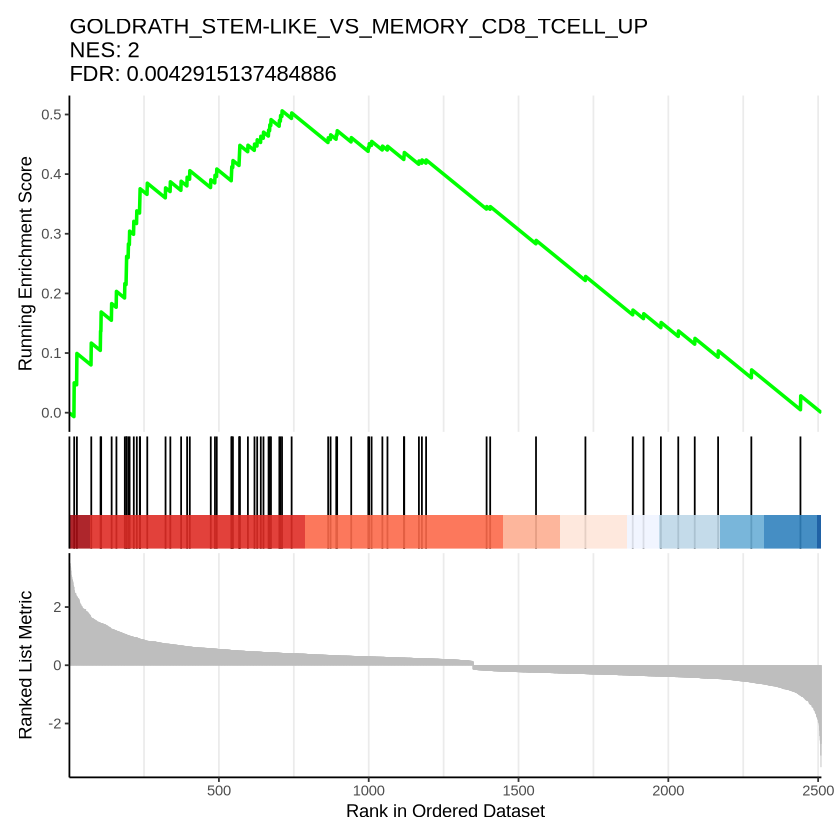

In [83]:
id = gsea_results@result$ID == 'GOLDRATH_NAIVE_VS_MEMORY_CD8_TCELL_UP'
# gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[id], title = gsea_results@result$Description[id])

p1 <- gseaplot2(
  gsea_results,
  geneSetID = gsea_results@result$ID[id],
  title = paste('GOLDRATH_STEM-LIKE_VS_MEMORY_CD8_TCELL_UP', "\nNES:", round(gsea_results@result$NES[id], 2),
    "\nFDR:", gsea_results@result$qvalue[id]),
  color = "green"
)

print(p1)

# 保存为PDF文件
ggsave("./plots/T_ros_gsea_plots.pdf", plot = p1, width = 7, height = 4)

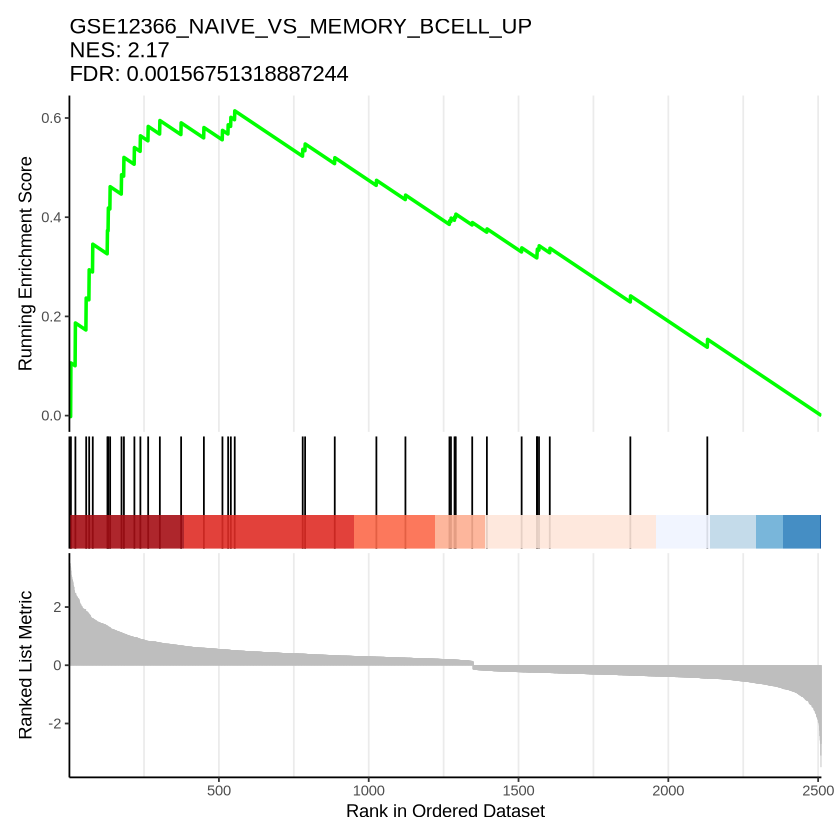

In [78]:
id = gsea_results@result$ID == 'GSE16522_MEMORY_VS_NAIVE_ANTI_CD3CD28_STIM_CD8_TCELL_DN'
# gseaplot2(gsea_results, geneSetID = gsea_results@result$ID[id], title = gsea_results@result$Description[id])

p1 <- gseaplot2(
  gsea_results,
  geneSetID = gsea_results@result$ID[id],
  title = paste(gsea_results@result$Description[id], "\nNES:", round(gsea_results@result$NES[id], 2),
    "\nFDR:", gsea_results@result$qvalue[id]),
  color = "green"
)

print(p1)

# 保存为PDF文件
ggsave("./plots/T_ros_gsea_plots.pdf", plot = p1, width = 7, height = 4)

In [5]:
gene_list <- tab %>% filter(padj < 1e-10) %>% filter(log2FoldChange > 0.5)

ego <- enrichGO(gene          = gene_list$Gene_name, 
                OrgDb         = org.Mm.eg.db, 
                ont           = "BP", 
                keyType = "SYMBOL",
                pAdjustMethod = "fdr", 
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2,
                readable = T)

In [8]:
library(enrichR)

ERROR: Error in library(enrichR): there is no package called ‘enrichR’


In [5]:
gene_list <- tab %>% filter(padj < 1e-10) %>% filter(log2FoldChange > 0.5)
ego <- enrichr(genes = gene_list$Gene_name,
               databases = "C7_IMMUNESIGDB")$C7_IMMUNESIGDB %>%
       filter(Adjusted.P.value < 0.05) %>%
       arrange(Adjusted.P.value)

ERROR: Error in enrichr(genes = gene_list$Gene_name, databases = "C7_IMMUNESIGDB"): could not find function "enrichr"


In [6]:
ego2 = simplify(ego, cutoff=0.7, by="p.adjust", select_fun=min)

In [7]:
ego3 = gofilter(ego2, level = 4)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


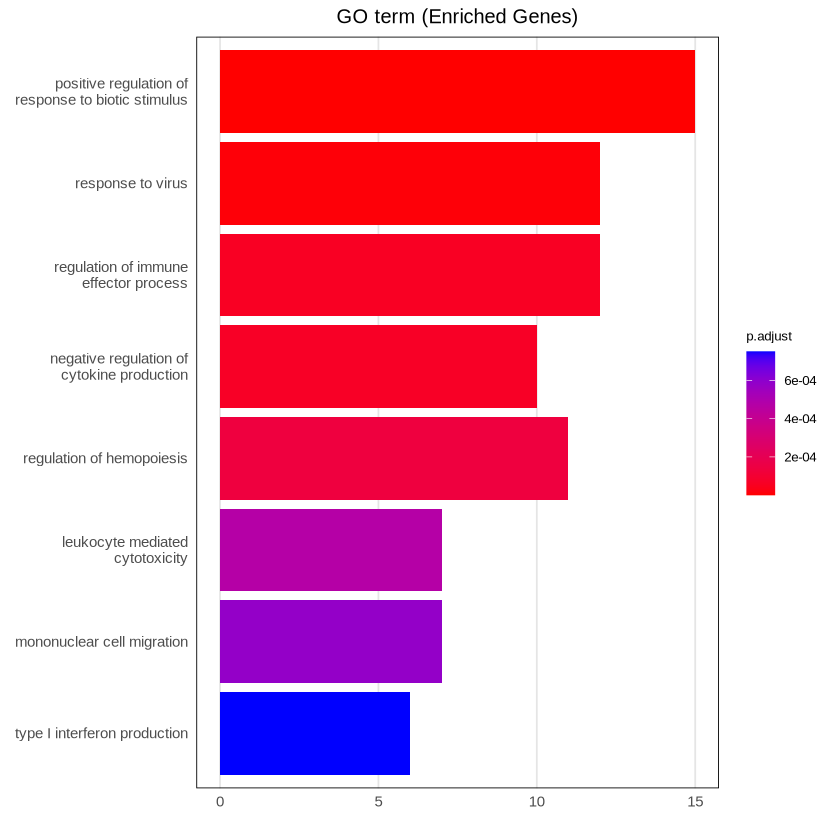

In [8]:
# 绘制GO富集分析的条形图
p <- barplot(ego3, 
            showCategory = 8,
            font.size = 10) +
  ggtitle("GO term (Enriched Genes)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 12, hjust = 0.5),
    axis.title.x = element_text(size = 10),
    axis.title.y = element_blank(), 
    axis.text = element_text(size = 9),
    panel.grid.major.x = element_line(color = "gray90"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA), # 添加外框
    legend.position = "right",
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  ) +
  scale_fill_gradient(
    low = "red", # 调整顺序为红色在上
    high = "blue", # 蓝色在下
    name = "p.adjust"
  ) +
  xlab("")

# 保存图片
# ggsave('./plots/GO_enrichment_barplot.pdf', p, width = 8, height = 6)

print(p)


In [14]:
ego@result %>% write.csv('./plots/GO_enrichment_high.csv')

In [9]:
gene_list <- tab %>% filter(padj < 1e-10) %>% filter(log2FoldChange < -0.5)

ego_low <- enrichGO(gene          = gene_list$Gene_name, 
                OrgDb         = org.Mm.eg.db, 
                ont           = "BP", 
                keyType = "SYMBOL",
                pAdjustMethod = "fdr", 
                pvalueCutoff  = 0.05,
                qvalueCutoff  = 0.2,
                readable = T)

In [13]:
ego_low@result %>% write.csv('./plots/GO_enrichment_low.csv')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


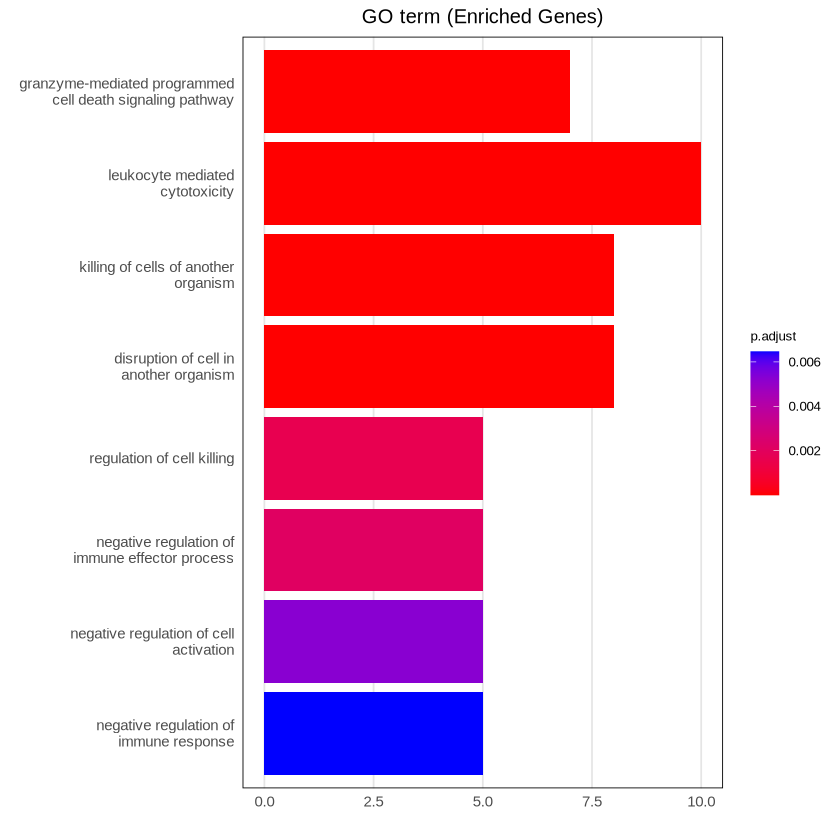

In [10]:
ego2_low = simplify(ego_low, cutoff=0.7, by="p.adjust", select_fun=min)
ego3_low = gofilter(ego2_low, level = 4)

# 绘制GO富集分析的条形图
p <- barplot(ego3_low, 
            showCategory = 8,
            font.size = 10) +
  ggtitle("GO term (Enriched Genes)") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 12, hjust = 0.5),
    axis.title.x = element_text(size = 10),
    axis.title.y = element_blank(), 
    axis.text = element_text(size = 9),
    panel.grid.major.x = element_line(color = "gray90"),
    panel.grid.major.y = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_rect(color = "black", fill = NA), # 添加外框
    legend.position = "right",
    legend.title = element_text(size = 8),
    legend.text = element_text(size = 8)
  ) +
  scale_fill_gradient(
    low = "red", # 调整顺序为红色在上
    high = "blue", # 蓝色在下
    name = "p.adjust"
  ) +
  xlab("")

# 保存图片
# ggsave('./plots/GO_enrichment_barplot.pdf', p, width = 8, height = 6)

print(p)

In [7]:
deseq2_out <- read.csv('./bulkdata/Group_CD44SPP1_vs_interSPP1_DESeq2.txt', sep = '\t')
spp1_results <- deseq2_out

In [9]:
deseq2_out_sorted <- deseq2_out %>% 
  filter(!is.na(padj)) %>% 
  arrange(padj)

Saving 7 x 7 in image


Warning message:
“ggrepel: 513 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 513 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


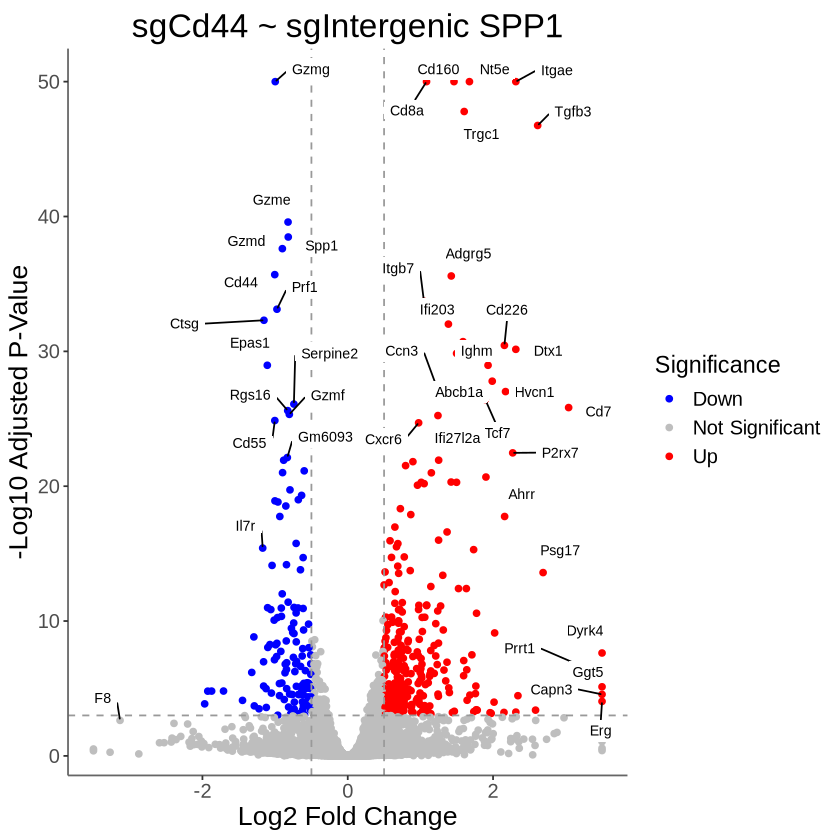

In [7]:
library(ggplot2)
library(ggrepel)

tab <- deseq2_out_sorted

tab$padj <- ifelse(tab$padj < 1e-50, 1e-50, tab$padj)
tab$log2FoldChange <- ifelse(tab$log2FoldChange > 3.5, 3.5, tab$log2FoldChange)
tab$log2FoldChange <- ifelse(tab$log2FoldChange < -3.5, -3.5, tab$log2FoldChange)

# Assign colors based on fold change and significance
tab$color <- 'Not Significant'
tab$color[tab$log2FoldChange > 0.5 & tab$padj < 0.001] <- 'Up'
tab$color[tab$log2FoldChange < -0.5 & tab$padj < 0.001] <- 'Down'
tab$color <- factor(tab$color, levels = c('Down', 'Not Significant', 'Up'))

# Create the plot with soft colors and labeled genes
p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = color), size = 1.5) +
  scale_color_manual(values = c("blue", "gray", "red")) +  # 改为红色和蓝色
  theme_classic() +
  labs(
    title = "sgCd44 ~ sgIntergenic SPP1",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-3.5, 3.5), ylim = c(1, 50)) +
  geom_hline(yintercept = -log10(0.001), linetype = "dashed", color = "gray60") +
  geom_vline(xintercept = c(-0.5, 0.5), linetype = "dashed", color = "gray60") +
  geom_label_repel(
    data = subset(tab, (padj < 0.01) & (abs(log2FoldChange) > 0.5)),
    aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.4,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, vjust = 0.3),  # Title size
    axis.title = element_text(size = 16),  # Axis title size
    axis.text = element_text(size = 12),   # Axis label size
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),  # Legend text size
    axis.line = element_line(size = 0.5, color = "gray40"), # Softer axis lines
    panel.grid.major = element_blank(), panel.grid.minor = element_blank() # Clean gridlines
  )

# Save the plot
ggsave('./plots/sgCd44_vs_sgIntergenic_SPP1.pdf', p, dpi=600)

print(p)

In [10]:
# 标记上调和下调基因
pbs_results$direction <- ifelse(pbs_results$log2FoldChange > 0.5 & pbs_results$padj < 0.001, "Up",
                                 ifelse(pbs_results$log2FoldChange < -0.5 & pbs_results$padj < 0.001, "Down", "Not Significant"))

spp1_results$direction <- ifelse(spp1_results$log2FoldChange > 0.5 & spp1_results$padj < 0.001, "Up",
                                  ifelse(spp1_results$log2FoldChange < -0.5 & spp1_results$padj < 0.001, "Down", "Not Significant"))

# 找到原本上调/下调，处理后不再上下调的基因
no_change_genes <- merge(pbs_results[pbs_results$direction != "Not Significant", c("Gene_name", "direction")]  %>% filter(!is.na(direction)),
                          spp1_results[spp1_results$direction == "Not Significant", c("Gene_name", "direction")]  %>% filter(!is.na(direction)),
                          by = "Gene_name", suffixes = c("_pbs", "_spp1"), all = FALSE)

# 找到原本上调/下调，处理后相反的基因
reverse_change_genes <- merge(pbs_results[pbs_results$direction != "Not Significant", c("Gene_name", "direction")]  %>% filter(!is.na(direction)),
                               spp1_results[spp1_results$direction != "Not Significant", c("Gene_name", "direction")]  %>% filter(!is.na(direction)),
                               by = "Gene_name", suffixes = c("_pbs", "_spp1"), all = FALSE)

reverse_change_genes <- reverse_change_genes %>% filter(direction_pbs != direction_spp1)

# 输出结果
print("不再上下调的基因:")
print(no_change_genes)

print("上下调相反的基因:")
print(reverse_change_genes)


[1] "不再上下调的基因:"
        Gene_name direction_pbs  direction_spp1
1   4732440D04Rik          Down Not Significant
2   6430571L13Rik            Up Not Significant
3          Abhd15            Up Not Significant
4           Abhd8            Up Not Significant
5           Acat2            Up Not Significant
6           Acss1            Up Not Significant
7           Actn2            Up Not Significant
8           Agfg2            Up Not Significant
9             Ak4          Down Not Significant
10          Anxa3          Down Not Significant
11          Arap3            Up Not Significant
12       Arhgap39            Up Not Significant
13       Arhgef18            Up Not Significant
14       Arhgef39            Up Not Significant
15        Arhgef9          Down Not Significant
16          Arrb1            Up Not Significant
17       Atp6v1c1            Up Not Significant
18         Atpaf1            Up Not Significant
19          Aurka            Up Not Significant
20          Aurkb       

In [12]:
# 合并pbs_results和spp1_results
combined_results <- merge(pbs_results, spp1_results, by = "Gene_name", suffixes = c("_pbs", "_spp1"))

combined_results$log2FoldChange_pbs <- ifelse(combined_results$log2FoldChange_pbs > 3, 3, combined_results$log2FoldChange_pbs)
combined_results$log2FoldChange_spp1 <- ifelse(combined_results$log2FoldChange_spp1 > 3, 3, combined_results$log2FoldChange_spp1)

# 添加颜色列
combined_results$color <- ifelse(combined_results$direction_pbs == "Up" & combined_results$direction_spp1 == "Up", "red",
                                  ifelse(combined_results$direction_pbs == "Down" & combined_results$direction_spp1 == "Down", "blue",
                                         ifelse(combined_results$direction_pbs == "Up" & combined_results$direction_spp1 == "Not Significant", "tomato",
                                                ifelse(combined_results$direction_pbs == "Down" & combined_results$direction_spp1 == "Not Significant", "royalblue",
                                                       ifelse(combined_results$direction_pbs == "Not Significant" & combined_results$direction_spp1 == "Up", "maroon",
                                                              ifelse(combined_results$direction_pbs == "Not Significant" & combined_results$direction_spp1 == "Down", "navy",
                                                                     "gray"))))))

# 绘制log2FoldChange的散点图
library(ggplot2)
library(ggrepel)

p <- ggplot(combined_results[!is.na(combined_results$color), ], aes(x = log2FoldChange_pbs, y = log2FoldChange_spp1, color = color)) +
  geom_point(alpha = 0.8) +
  geom_text_repel(data = subset(combined_results[!is.na(combined_results$color), ], color != "gray"), aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.2,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  coord_cartesian(xlim = c(-3, 3), ylim = c(-3, 3)) +
  labs(title = "Not Treated vs Spp1 Treated Log2 Fold Change Comparison",
       x = "Not Treated Log2 Fold Change",
       y = "Spp1 Treated Log2 Fold Change") +
  scale_color_manual(values = c("red" = "red", "blue" = "blue", "tomato" = "tomato", 
                                  "royalblue" = "royalblue", "maroon" = "maroon", 
                                  "navy" = "navy"),
                     labels = c("red" = "Both Up", 
                                "blue" = "Both Down", 
                                "tomato" = "Not Treated Up", 
                                "royalblue" = "Not Treated Down", 
                                "maroon" = "Treated Up", 
                                "navy" = "Treated Down")) +
  theme_minimal() +
  theme(legend.title = element_blank())  # 去掉图例标题

ggsave('./plots/sgCd44_vs_sgIntergenic_SPP1_PBS.pdf', p, dpi=600)


Warning message in geom_text_repel(data = subset(combined_results[!is.na(combined_results$color), :
“Ignoring unknown parameters: `fill`, `label.size`, and `label.r`”
Saving 7 x 7 in image
Warning message:
“ggrepel: 631 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [11]:
library(DESeq2)

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowA

In [2]:
setwd('/home/wpy/stereoseq/20240502-SPACseq')
pbs_data <- read.csv('./bulkdata/Group_CD44PBS_vs_interPBS_TPMs.txt', sep = '\t')
spp1_data <- read.csv('./bulkdata/Group_CD44SPP_vs_interSPP1_TPMs.txt', sep = '\t')

# 取spp1_data的CD44列和pbs_data的CD44列变成一个dataframe
spp1_cd44 <- spp1_data[, c("CD44_SPP1_1", "CD44_SPP1_2", "CD44_SPP1_3")]
pbs_cd44 <- pbs_data[, c("CD44_PBS_1", "CD44_PBS_2", "CD44_PBS_3")]

# 合并两个dataframe
combined_cd44 <- data.frame(spp1_cd44, pbs_cd44)

# 取两个Data的inter列为一个dataframe
spp1_inter <- spp1_data[, c("inter_SPP1_1", "inter_SPP1_2", "inter_SPP1_3")]
pbs_inter <- pbs_data[, c("inter_PBS_1", "inter_PBS_2", "inter_PBS_3")]
combined_inter <- data.frame(spp1_inter, pbs_inter)

head(combined_cd44)

,CD44_SPP1_1,CD44_SPP1_2,CD44_SPP1_3,CD44_PBS_1,CD44_PBS_2,CD44_PBS_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0610005C13Rik,17.000,8.000,7.000,12.000,9.000,16
0610006L08Rik,0.000,0.000,0.000,0.000,0.000,0
0610009B22Rik,214.000,197.000,232.000,197.000,191.000,230
0610009E02Rik,2.000,20.818,20.683,5.233,8.064,0
0610009L18Rik,23.000,17.000,12.000,11.000,19.000,15
0610010F05Rik,421.001,389.999,333.001,337.001,339.000,348


In [6]:
length(unique(rownames(pbs_data)))

[1] 55291

In [21]:
# 确保数据是整数类型
combined_cd44 <- round(combined_cd44)

dds <- DESeqDataSetFromMatrix(countData = combined_cd44,
                              colData = data.frame(condition = factor(c(rep("Spp1", ncol(spp1_cd44)), rep("PBS", ncol(pbs_cd44))))),
                              design = ~ condition)

dds <- DESeq(dds)
results_dds <- results(dds)

cd44_results <- as.data.frame(results_dds) %>%
    filter(!is.na(padj)) %>%
    arrange(padj)

head(cd44_results)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CT010467.1,7172.501,-0.6046504,0.06760477,-8.943902,3.756658e-19,1.466975e-15
Jund,6817.423,-0.4015494,0.07111246,-5.646681,1.635747e-08,3.193797e-05
Arf6,6611.732,-0.2717879,0.05875586,-4.625715,3.733083e-06,4.859229e-03
Gm20716,1307.325,0.3235026,0.07596677,4.258475,2.058261e-05,1.636736e-02
Hnrnpa0,6760.775,-0.2503515,0.05884471,-4.254444,2.095693e-05,1.636736e-02
Basp1,1590.859,-0.2599848,0.06286074,-4.135885,3.535896e-05,2.070335e-02


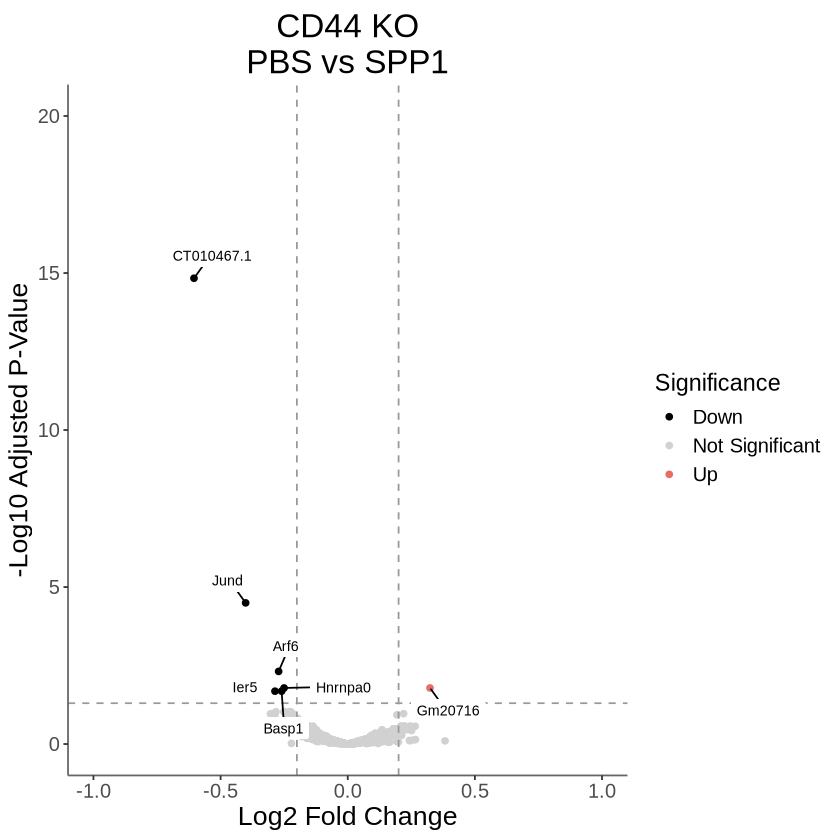

In [30]:
library(ggplot2)
library(ggrepel)

p_value_threshold <- 0.05
l2fc_threshold <- 0.2
tab <- cd44_results

tab$Gene_name <- rownames(tab)

tab$padj <- ifelse(tab$padj < 1e-50, 1e-50, tab$padj)
tab$log2FoldChange <- ifelse(tab$log2FoldChange > 1, 1, tab$log2FoldChange)
tab$log2FoldChange <- ifelse(tab$log2FoldChange < -1, -1, tab$log2FoldChange)

# Assign colors based on fold change and significance
tab$color <- 'Not Significant'
tab$color[tab$log2FoldChange > l2fc_threshold & tab$padj < p_value_threshold] <- 'Up'
tab$color[tab$log2FoldChange < -l2fc_threshold & tab$padj < p_value_threshold] <- 'Down'
tab$color <- factor(tab$color, levels = c('Down', 'Not Significant', 'Up'))

# Create the plot with soft colors and labeled genes
p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = color), size = 1.5) +
  scale_color_manual(values = c("#000000", "#D1D1D1", "#E66D65")) +  # Softer colors
  theme_classic() +
  labs(
    title = "CD44 KO\nPBS vs SPP1",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-1, 1), ylim = c(0, 20)) +
  geom_hline(yintercept = -log10(p_value_threshold), linetype = "dashed", color = "gray60") +
  geom_vline(xintercept = c(-l2fc_threshold, l2fc_threshold), linetype = "dashed", color = "gray60") +
  geom_label_repel(
    data = subset(tab, (padj < p_value_threshold) & (abs(log2FoldChange) > l2fc_threshold)),
    aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.4,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, vjust = 0.3),  # Title size
    axis.title = element_text(size = 16),  # Axis title size
    axis.text = element_text(size = 12),   # Axis label size
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),  # Legend text size
    axis.line = element_line(size = 0.5, color = "gray40"), # Softer axis lines
    panel.grid.major = element_blank(), panel.grid.minor = element_blank() # Clean gridlines
  )

# Save the plot
# ggsave('co-culture_updated.pdf', p, dpi=600)

print(p)

In [20]:
# 确保数据是整数类型
combined_inter <- round(combined_inter)

dds <- DESeqDataSetFromMatrix(countData = combined_inter,
                              colData = data.frame(condition = factor(c(rep("Spp1", ncol(spp1_inter)), rep("PBS", ncol(pbs_inter))))),
                              design = ~ condition)

dds <- DESeq(dds)
results_dds <- results(dds)

inter_results <- as.data.frame(results_dds) %>%
    filter(!is.na(padj)) %>%
    arrange(padj)

head(inter_results)

converting counts to integer mode

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gm29253,13.769292,3.3949862,0.73707193,4.606045,4.104005e-06,0.08643445
0610009E02Rik,9.313739,4.0894847,1.06103679,3.854235,1.160923e-04,0.81271316
Gm20402,4.057787,5.4250840,1.47345963,3.681868,2.315312e-04,0.81271316
Hist1h2bq,4.197333,5.4750410,1.46269360,3.743122,1.817477e-04,0.81271316
Hist1h2br,4.086848,-5.5160617,1.46969257,-3.753208,1.745860e-04,0.81271316
Srp54c,942.718705,-0.3143391,0.08515133,-3.691535,2.229051e-04,0.81271316


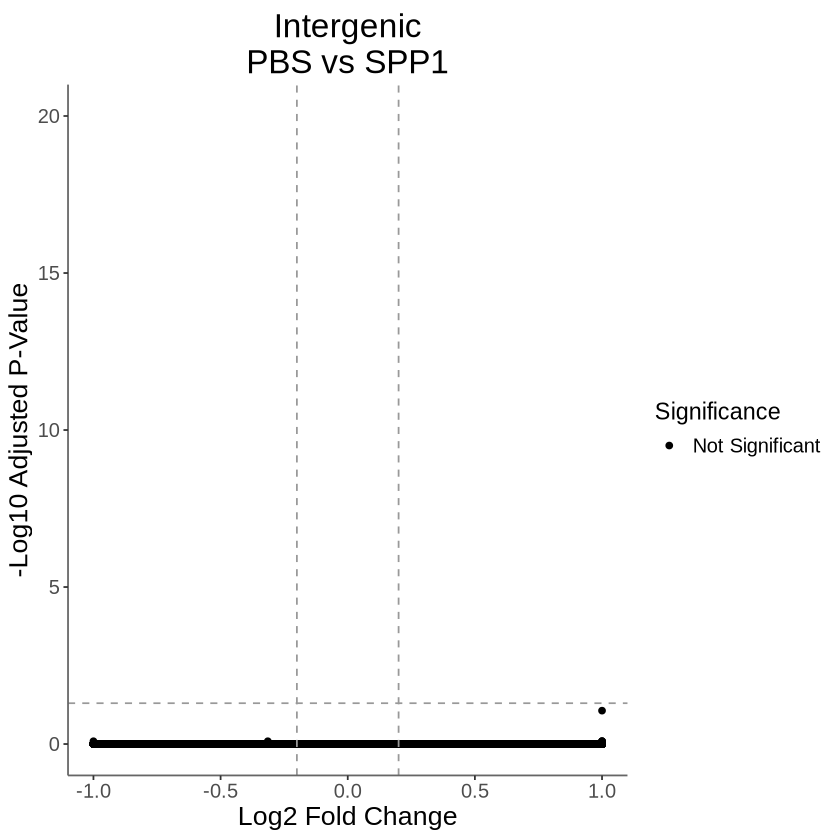

In [38]:
library(ggplot2)
library(ggrepel)

p_value_threshold <- 0.05
l2fc_threshold <- 0.2
tab <- inter_results

tab$Gene_name <- rownames(tab)

tab$padj <- ifelse(tab$padj < 1e-50, 1e-50, tab$padj)
tab$log2FoldChange <- ifelse(tab$log2FoldChange > 1, 1, tab$log2FoldChange)
tab$log2FoldChange <- ifelse(tab$log2FoldChange < -1, -1, tab$log2FoldChange)

# Assign colors based on fold change and significance
tab$color <- 'Not Significant'
tab$color[tab$log2FoldChange > l2fc_threshold & tab$padj < p_value_threshold] <- 'Up'
tab$color[tab$log2FoldChange < -l2fc_threshold & tab$padj < p_value_threshold] <- 'Down'
tab$color <- factor(tab$color, levels = c('Down', 'Not Significant', 'Up'))

# Create the plot with soft colors and labeled genes
p <- ggplot(tab, aes(x = log2FoldChange, y = -log10(padj))) +
  geom_point(aes(color = color), size = 1.5) +
  scale_color_manual(values = c("#000000", "#D1D1D1", "#E66D65")) +  # Softer colors
  theme_classic() +
  labs(
    title = "Intergenic\nPBS vs SPP1",
    x = "Log2 Fold Change",
    y = "-Log10 Adjusted P-Value",
    color = 'Significance'
  ) +
  coord_cartesian(xlim = c(-1, 1), ylim = c(0, 20)) +
  geom_hline(yintercept = -log10(p_value_threshold), linetype = "dashed", color = "gray60") +
  geom_vline(xintercept = c(-l2fc_threshold, l2fc_threshold), linetype = "dashed", color = "gray60") +
  geom_label_repel(
    data = subset(tab, (padj < p_value_threshold) & (abs(log2FoldChange) > l2fc_threshold)),
    aes(label = Gene_name),
    size = 3, fill = "white",
    box.padding = 0.4,
    label.size = 0,  # 去除label外围的框
    label.r = unit(0.2, "lines"), # Rounded corners
    color = "black"
  ) +
  theme(
    plot.title = element_text(size = 20, hjust = 0.5, vjust = 0.3),  # Title size
    axis.title = element_text(size = 16),  # Axis title size
    axis.text = element_text(size = 12),   # Axis label size
    legend.title = element_text(size = 14),
    legend.text = element_text(size = 12),  # Legend text size
    axis.line = element_line(size = 0.5, color = "gray40"), # Softer axis lines
    panel.grid.major = element_blank(), panel.grid.minor = element_blank() # Clean gridlines
  )

# Save the plot
# ggsave('co-culture_updated.pdf', p, dpi=600)

print(p)